In [1]:
!ls

baseline_age.ipynb	 move_datasets.ipynb  sample_submission.ipynb
baseline_gender.ipynb	 requirements.txt     split_dataset.ipynb
baseline_mask.pth	 resnet_age.ipynb     submission_mask.csv
baseline_mask_cpu.ipynb  resnet_gender.ipynb
baseline_mask_gpu.ipynb  resnet_mask.ipynb


In [2]:
import os
import shutil

task = "mask"
ORIGINAL_DATASET_PATH = "../labeled/"
ORIGINAL_DATASET_PATH = os.path.join(ORIGINAL_DATASET_PATH, task)
classes_list = os.listdir(ORIGINAL_DATASET_PATH)
classes_list = [x for x in classes_list if not x.startswith('.')]
classes_list

['incorrect', 'wear', 'not_wear']

In [3]:
# Make base directory for train, test, val
BASE_DIR = "../splitted"
BASE_DIR = os.path.join(BASE_DIR, task)

# define paths for train, test, val underneath BASE_DIR
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")
test_dir = os.path.join(BASE_DIR, "test")

In [4]:
import torch
import os

""" 
Predefining cuda, device settings
Predefining BATCH_SIZE, EPOCHS, base directory path for (splitted) dataset.
"""

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# DEVICE = torch.device("cpu")
BATCH_SIZE = 256
EPOCH = 10
DEVICE

device(type='cuda')

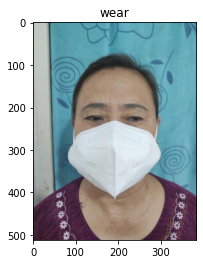

In [5]:
# sample image from train, val, test
import random

sample_train_class = random.choice(os.listdir(train_dir))
sample_train_img = random.choice(os.listdir(os.path.join(train_dir, sample_train_class)))
sample_train_img_path = os.path.join(train_dir, sample_train_class, sample_train_img)
sample_train_img_path

# display image based on sample_train_img_path using cv2
from matplotlib import pyplot as plt
import cv2

# https://gist.github.com/mstfldmr/45d6e47bb661800b982c39d30215bc88
img = cv2.imread(sample_train_img_path)
colored_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(colored_image)
plt.title(sample_train_class)
plt.show()


In [6]:
from pathlib import Path

def check_valid(path):
    path = Path(path)
    return not path.stem.startswith('._')


In [7]:
# Dataset loader and transformation

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

base_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
])
train_dataset = ImageFolder(root=os.path.join(BASE_DIR, "train"), transform=base_transform, is_valid_file=check_valid)
val_dataset = ImageFolder(root=os.path.join(BASE_DIR, "val"), transform=base_transform, is_valid_file=check_valid)

train_loader = torch.utils.data.DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=2
  )

val_loader = torch.utils.data.DataLoader(
  dataset=val_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=2
  )

In [8]:
# Structuring baseline neural network

import torch.nn as nn
import torch.nn.functional as F

class BaselineNet(nn.Module):
  def __init__(self):
    """ 
    Configuraing convolution layer / fully connected layers
    """
    super(BaselineNet, self).__init__()
    
    # convolution filter settings
    self.conv1 = nn.Conv2d(
      in_channels=3,
      out_channels=32, 
      kernel_size=3, 
      padding=1
      )
    self.conv2 = nn.Conv2d(
      in_channels=32,
      out_channels=64,
      kernel_size=3,
      padding=1
      )
    self.conv3 = nn.Conv2d(
      in_channels=64,
      out_channels=64,
      kernel_size=3,
      padding=1
      )
    
    # pooling layer settings
    self.pool = nn.MaxPool2d(
      kernel_size=2, 
      stride=2
      )

    # fully connected layer settings
    # how to determine the size of the output of the last conv layer?
    self.fc1 = nn.Linear(
      in_features=64 * 64,
      out_features=128
      )

    self.fc2 = nn.Linear(
      in_features=128,
      out_features=len(classes_list)
      )
  def forward(self, x):
    """ Forward pass of the model using predefined configuration settings on BaselineNet """

    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training) # training: boolean type for training mode

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    # what is the difference between flatten and view?: https://discuss.pytorch.org/t/what-is-the-difference-of-flatten-and-view-1-in-pytorch/51790
    # Flatten: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
    
    # fixing to 4096 regardless of output shape, similar to VGG having fully connected layer as 4096
    # https://stackoverflow.com/questions/42733971/understanding-the-dimensions-of-a-fully-connected-layer-that-follows-a-max-pooli
    # https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
    # https://stats.stackexchange.com/questions/221691/is-there-a-heuristic-for-determining-the-size-of-a-fully-connected-layer-at-the
    x = x.view(-1, 4096) # same as x.flatten(), but view can designate the flattened size I guess.
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.fc2(x)
    
    return F.log_softmax(x, dim=1)

    

In [9]:
import torch.optim as optim

model_base = BaselineNet().to(DEVICE) # allocating model instance to DEVICE
optimizer = optim.Adam(model_base.parameters(), lr=1e-3) # setting up optimizer

In [10]:
""" train """

LOG_INTERVAL = 10 # logging training progress every 10 batches

def train(input_model, train_loader, optimizer, epoch):
  """ Training the input_model """
  input_model.train() # train mode for the input model
  # using enumerate to get the index of the image in the batch, (img_data, class)
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad() # initilizing the gradients to zero
    output = input_model(data) # forward pass
    loss = F.cross_entropy(output, target) # loss function
    loss.backward() # backward pass
    optimizer.step() # updating the weights

    if batch_idx % LOG_INTERVAL == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

In [11]:
""" validator """

def validation(input_model, test_loader):
  """ Validation the input_model """
  # using enumerate to get the index of the image in the batch, (img_data, class)
  input_model.eval() # eval mode for the input model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = input_model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      # difference between argmax vs max
      # argmax results in probability whearas max results in both tensor and probability
      correct += pred.eq(target.view_as(pred)).sum().item()
  
  test_loss /= len(test_loader.dataset)
  test_accruacy = 100. * correct / len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return test_loss, test_accruacy  


In [12]:
!nvidia-smi

Tue Aug 24 14:36:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   43C    P0    39W / 250W |   1059MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
from torchsummary import summary
summary(model_base, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 128]         524,416
            Linear-8                    [-1, 3]             387
Total params: 581,123
Trainable params: 581,123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.03
Params size (MB): 2.22
Estimated Total Size (MB): 4.30
----------------------------------------------------------------


In [14]:
model_base

BaselineNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [15]:
""" trainer """
import time
import copy

def trainer_baseline(input_model, train_loader, val_loader, optimizer, epochs=10):
  best_acc = 0.0 # initializing the best accuracy to 0
  best_input_model_wts = copy.deepcopy(input_model.state_dict()) # initializing the best model weights to the input model weights

  """ Trainer for baseline input_model """
  # training the input_model
  for epoch in range(1, epochs + 1):
    since = time.time()
    train(input_model, train_loader, optimizer, epoch)
    # evaluate the input_model
    with torch.no_grad():
      val_loss, val_acc = validation(input_model, val_loader)
    
    if val_acc > best_acc:
      best_acc = val_acc
      best_input_model_wts = copy.deepcopy(input_model.state_dict()) # update the best model weights

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
    print('Validation complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))

    input_model.load_state_dict(best_input_model_wts)

  return input_model

base = trainer_baseline(model_base, train_loader, val_loader, optimizer, epochs=10)
torch.save(base, f'baseline_{task}.pth')

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [ ]:
!nvidia-smi